In [2]:
# from analysis.moment_analysis import ModelsContainer
from sklearn.metrics import roc_auc_score
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
import os


from energyflow.archs.moment import EFN_moment, PFN_moment
from ModelsContainer import ModelsContainer

# plt.style.use('seaborn-white')



2023-08-28 16:16:48.963059: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-28 16:16:48.964481: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-28 16:16:48.989566: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-28 16:16:48.990183: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-28 16:16:49.429789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [3]:
pfn_string = "EFN"
dataset = "qg"
run_name = "latent"

num_models_to_train = 3 ##number of models to use to make error bars
order_list = [1,2, 3, 4] #
input_dim = 2
output_dim = 1
F_width = 25
Phi_width = 25


performance = {}
configs = {}
histories = {}


# Directory Handling
base_directory = f"Data/{dataset}_{pfn_string}_{run_name}"
plot_directory = f"Plots/{dataset}_{pfn_string}_{run_name}"
latent_directory = os.path.join(plot_directory, "latent_spaces")
os.makedirs(plot_directory, exist_ok = True)
os.makedirs(latent_directory, exist_ok = True)


for k in order_list:

    directory = os.path.join(base_directory, f"order_{k}")


    p = np.load(os.path.join(directory , "performance.npy"), allow_pickle=True)[()]
    h = np.load(os.path.join(directory ,"histories.npy"), allow_pickle=True)[()]
    c = np.load(os.path.join(directory , "configs.npy"), allow_pickle=True)[()]

    performance.update(p)
    configs.update(c)
    histories.update(h)


dataset_string = "Top/QCD" if dataset == "top" else "Quark/Gluon"




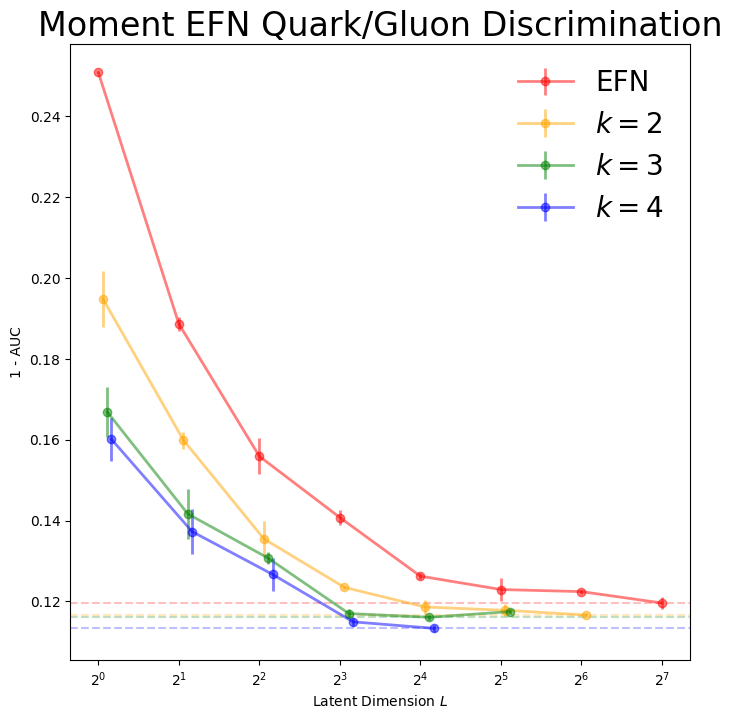

In [4]:
# print(histories.keys())

# colors = ["red", "orange", "green", "blue"]
# fig, axes = plt.subplots(1, 1, figsize=(8,8))
# plt.rcParams['font.size'] = '20'

# print(configs)


def effective_latent_dim(O, L):

    binom = scipy.special.binom(L+O, O+1)
    return int( (O+1) * binom / L)

# def dictionary_substring(dict, substring):

#     for key in dict:
#         if substring in key:
#             return dict[key]

# for (o,order) in enumerate(histories):
#     for sample in range(num_samples):
#         for model in range(num_models_to_train)[:1]:

#             print(order, sample, model, histories[order][sample][model].keys())
#             plt.plot(dictionary_substring(histories[order][sample][model], "val_auc"), color = colors[o], alpha = 0.25, lw = 3)


# plt.xlabel("epochs")


def plot(performance_dict):
    

    colors = ["red", "orange", "green", "blue", "purple", "black"]

    fig, axes = plt.subplots(figsize=(8,8))
    plt.rcParams['font.size'] = '20'


    for p, order in enumerate(order_list):
        x = []
        y = []
        yerr= []

        for (config,info) in zip(configs['Order '+str(order)], performance_dict['Order '+str(order)]):
            
            x.append(config[0])
            # x.append(latent_dim(order,  config[0]))
            # x.append(effective_latent_dim(order,  config[0]))


            y.append(info[1])
            yerr.append(info[2])
            
        # axes.scatter(x, y,  marker = "o", c=colors[p], label = r'$O = %d$ ' % order if order > 1 else "EFN", alpha = 0.5)
        x = np.asarray(x)
        y = np.asarray(y)
        # if p == 0:
        #     y = y * (1 - 1/(4*x))
        # yerr = np.asarray(yerr) 
        # if p == 0:
        #     # y = y * (1 - 1/(800*x))
        #     yerr = yerr * (1 + 1/(2*x))
        # axes.plot(x,1 -y, yerr, marker = "o", c=colors[p], label = r'$k = %d$ ' % order if order > 1 else "EFN", alpha = 0.5, linestyle='None')
        axes.errorbar(x * (1 + p / 25),1-y, yerr, marker = "o", c=colors[p], label = r'$k = %d$ ' % order if order > 1 else pfn_string, alpha = 0.5, lw = 2)

        min_y = np.min(1-y)
        min_x = np.argmin(1-y)
        plt.axhline(min_y, c=colors[p], ls = "--", alpha = 0.25)


    # Special Points
    # axes.scatter([82358,], [.8824], marker = "*", color = colors[0])


    plt.legend(frameon = False)
    plt.xlabel(r"Latent Dimension $L$")
    plt.ylabel("1 - AUC")
    plt.xscale("log", base = 2)
    # plt.ylim(.120, .325)
    plt.xticks((1, 2, 4, 8, 16, 32, 64, 128), [f"$2^{i}$" for i in range(8)])
    plt.title(f"Moment {pfn_string} {dataset_string} Discrimination")

    plt.savefig(os.path.join(plot_directory, "latent_dim.pdf"))
    plt.show()


plot(performance)

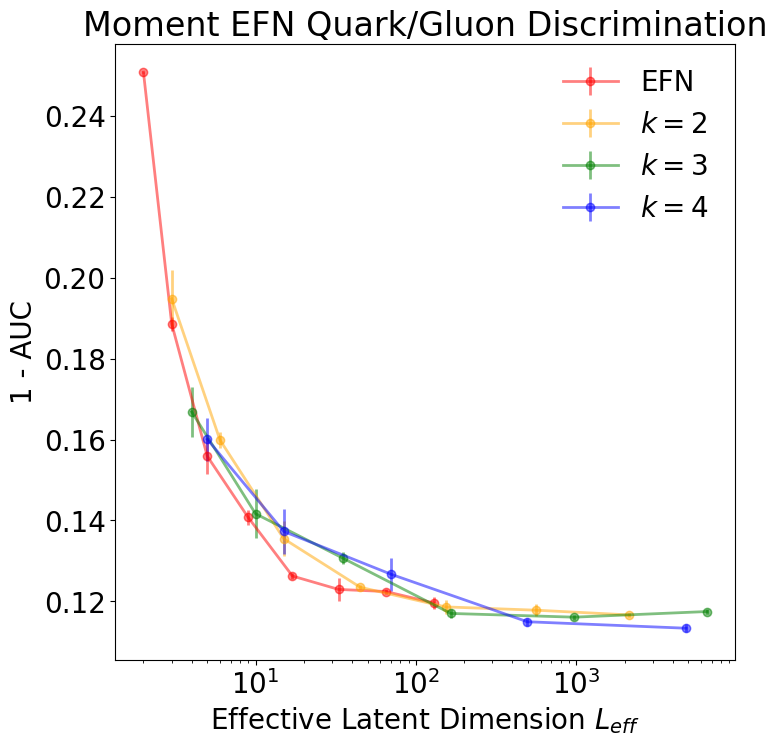

In [5]:
def plot(performance_dict):
    

    colors = ["red", "orange", "green", "blue", "purple", "black"]

    fig, axes = plt.subplots(figsize=(8,8))
    plt.rcParams['font.size'] = '20'


    for p, order in enumerate(order_list):
        x = []
        y = []
        yerr= []

        for (config,info) in zip(configs['Order '+str(order)], performance_dict['Order '+str(order)]):
            
            # x.append(config[0])
            # x.append(latent_dim(order,  config[0]))
            x.append(effective_latent_dim(order,  config[0]))


            y.append(info[1])
            yerr.append(info[2])
            
        # axes.scatter(x, y,  marker = "o", c=colors[p], label = r'$O = %d$ ' % order if order > 1 else "EFN", alpha = 0.5)
        x = np.asarray(x)
        y = np.asarray(y)
        # if p == 0:
        #     y = y * (1 - 1/(4*x))
        # yerr = np.asarray(yerr) 
        # if p == 0:
        #     # y = y * (1 - 1/(800*x))
        #     yerr = yerr * (1 + 1/(2*x))
        axes.errorbar(x,1 -y, yerr, marker = "o", c=colors[p], label = r'$k = %d$ ' % order if order > 1 else pfn_string, alpha = 0.5, lw = 2)


    # Special Points
    # axes.scatter([82358,], [.8824], marker = "*", color = colors[0])


    plt.legend(frameon = False)
    plt.xlabel(r"Effective Latent Dimension $L_{eff}$")
    plt.ylabel("1 - AUC")
    plt.xscale("log")
    # plt.ylim(.120, .325)
    plt.title(f"Moment {pfn_string} {dataset_string} Discrimination")

    plt.savefig(os.path.join(plot_directory, "effective_latent_dim.pdf"))
    plt.show()


plot(performance)

[128 100 100]
[ 64 100 100]
[ 32 100 100]
[ 16 100 100]
[  8 100 100]
[  4 100 100]
[  2 100 100]
[  1 100 100]
[ 64 100 100]
[ 32 100 100]
[ 16 100 100]
[  8 100 100]
[  4 100 100]
[  2 100 100]
[  1 100 100]
[ 32 100 100]
[ 16 100 100]
[  8 100 100]
[  4 100 100]
[  2 100 100]
[  1 100 100]
[ 16 100 100]
[  8 100 100]
[  4 100 100]
[  2 100 100]
[  1 100 100]


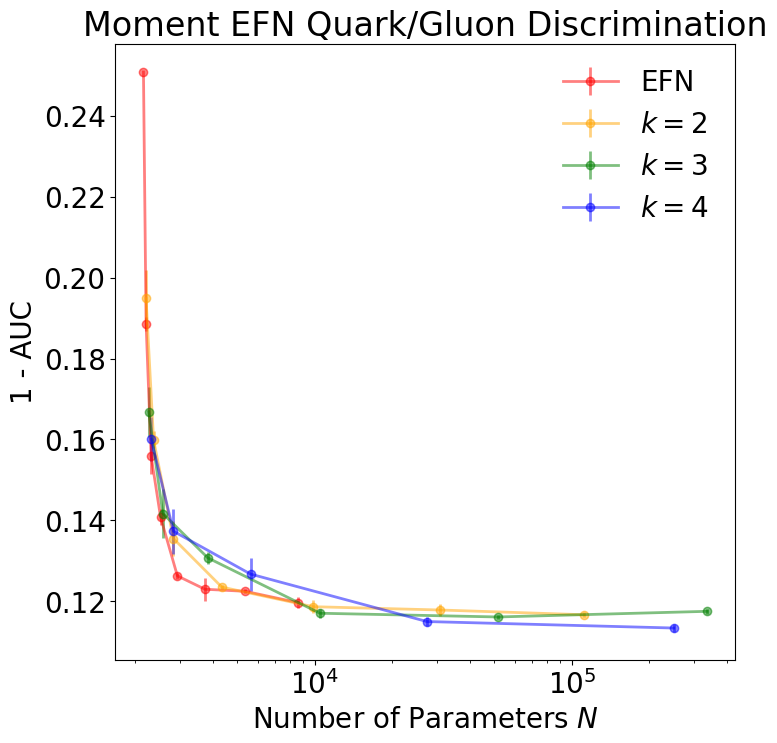

In [6]:

def num_params(input_dim, layers, output_dim):

    params = input_dim * (layers[0] + 1)
    for i in range(len(layers)-1):
        params = params + (layers[i])*(layers[i+1] +1)
    return params + (output_dim)*(layers[-1] + 1)


def plot(performance_dict):
    

    colors = ["red", "orange", "green", "blue", "purple", "black"]

    fig, axes = plt.subplots(figsize=(8,8))
    plt.rcParams['font.size'] = '20'


    for p, order in enumerate(order_list):
        x = []
        y = []
        yerr= []

        for (config,info) in zip(configs['Order '+str(order)], performance_dict['Order '+str(order)]):


            layers = [Phi_width, Phi_width, effective_latent_dim(order, config[0]), F_width, F_width, F_width]
            N = num_params(input_dim, layers, output_dim)
            
            x.append(N)
            print(config)
            # x.append(latent_dim(order,  config[0]))
            # x.append(effective_latent_dim(order,  config[0]))


            y.append(info[1])
            yerr.append(info[2])
            
        # axes.scatter(x, y,  marker = "o", c=colors[p], label = r'$O = %d$ ' % order if order > 1 else "EFN", alpha = 0.5)
        x = np.asarray(x)
        y = np.asarray(y)
        # if p == 0:
        #     y = y * (1 - 1/(4*x))
        # yerr = np.asarray(yerr) 
        # if p == 0:
        #     # y = y * (1 - 1/(800*x))
        #     yerr = yerr * (1 + 1/(2*x))
        axes.errorbar(x,1 -y, yerr, marker = "o", c=colors[p], label = r'$k = %d$ ' % order if order > 1 else pfn_string, alpha = 0.5, lw = 2)


    # Special Points
    # axes.scatter([82358,], [.8824], marker = "*", color = colors[0])


    plt.legend(frameon = False)
    plt.xlabel(r"Number of Parameters $N$")
    plt.ylabel("1 - AUC")
    plt.xscale("log")
    # plt.ylim(.120, .325)
    plt.title(f"Moment {pfn_string} {dataset_string} Discrimination")

    plt.savefig(os.path.join(plot_directory, "num_parameters.pdf"))
    plt.show()


plot(performance)

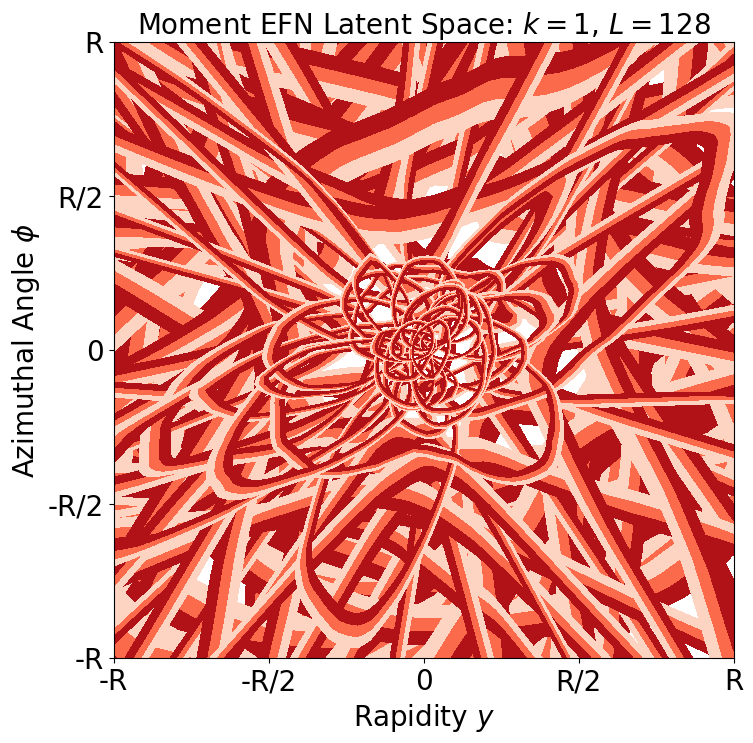

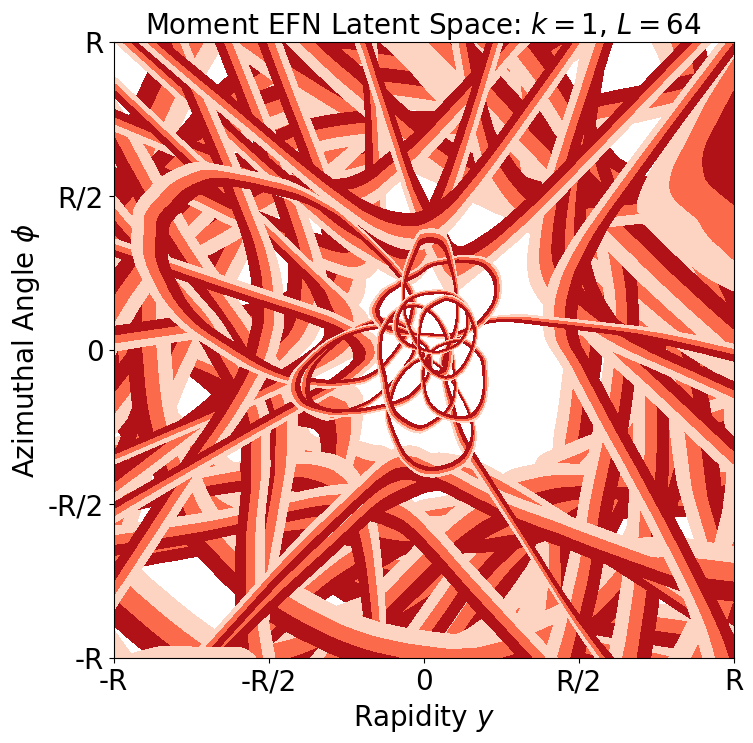

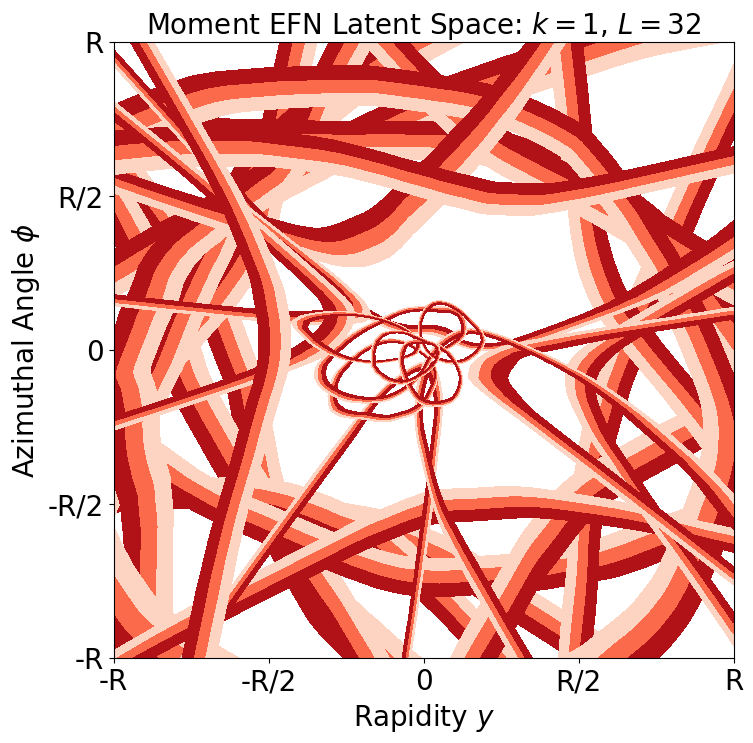

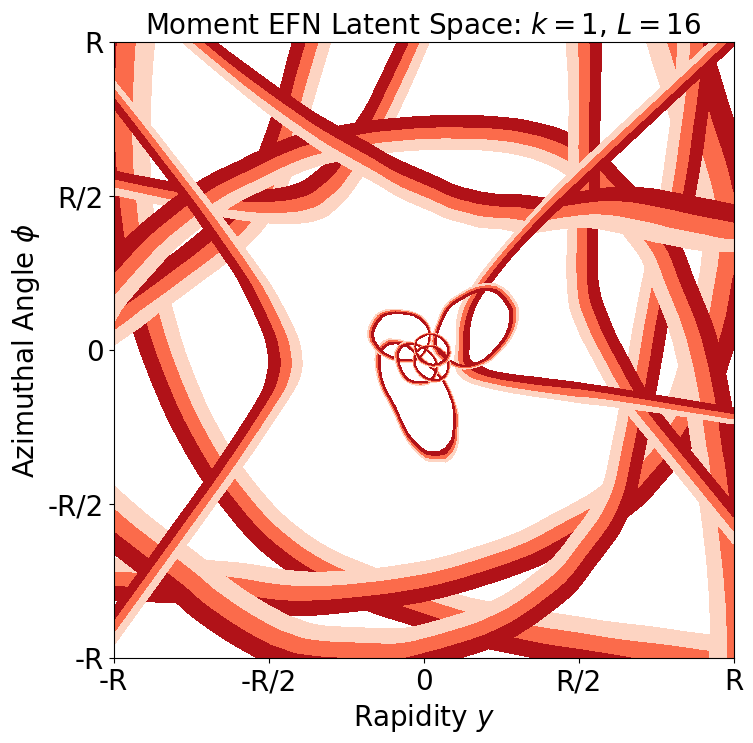

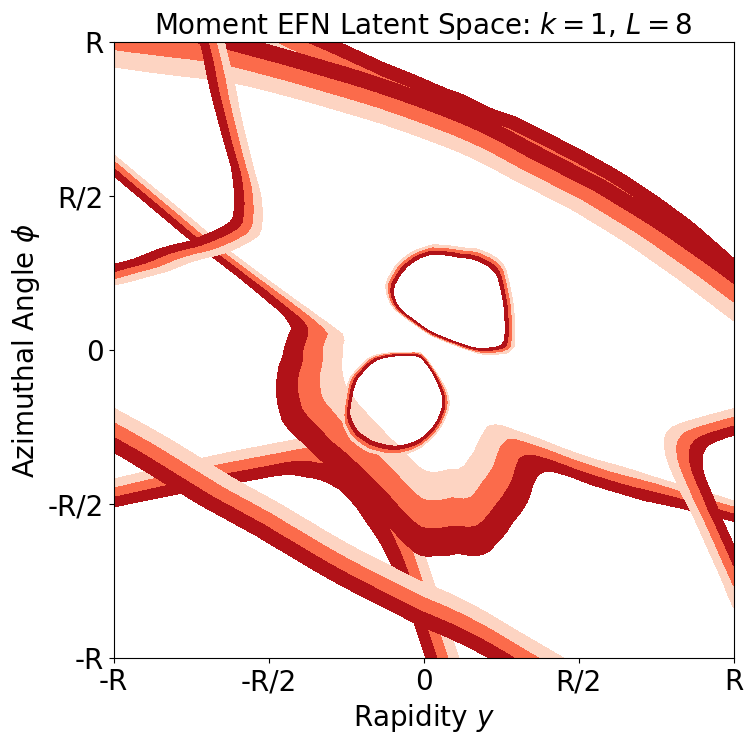

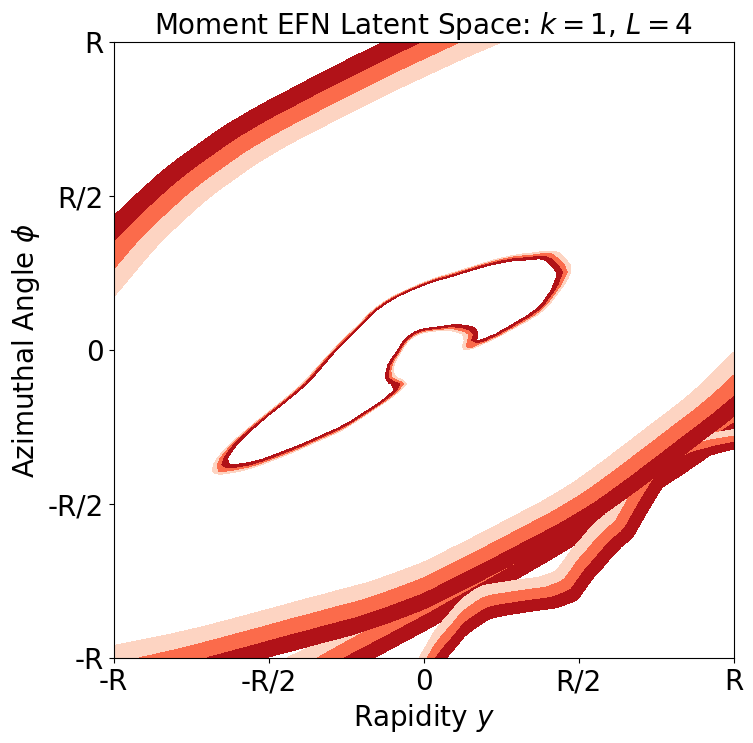

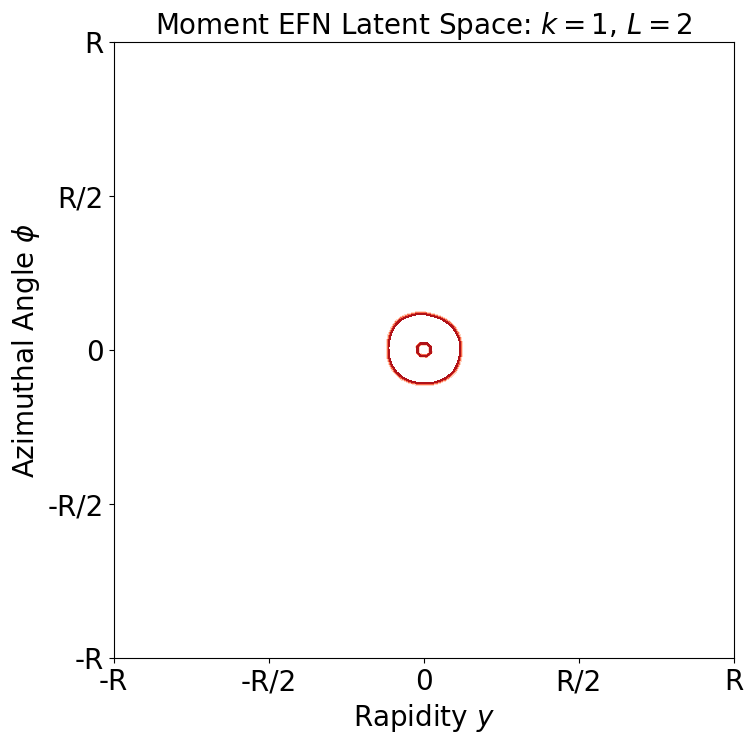

/tmp/ipykernel_43732/438350120.py:76: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contourf(X, Y, z/np.max(z), level = 25, cmap=subcolors[i % len(subcolors)])


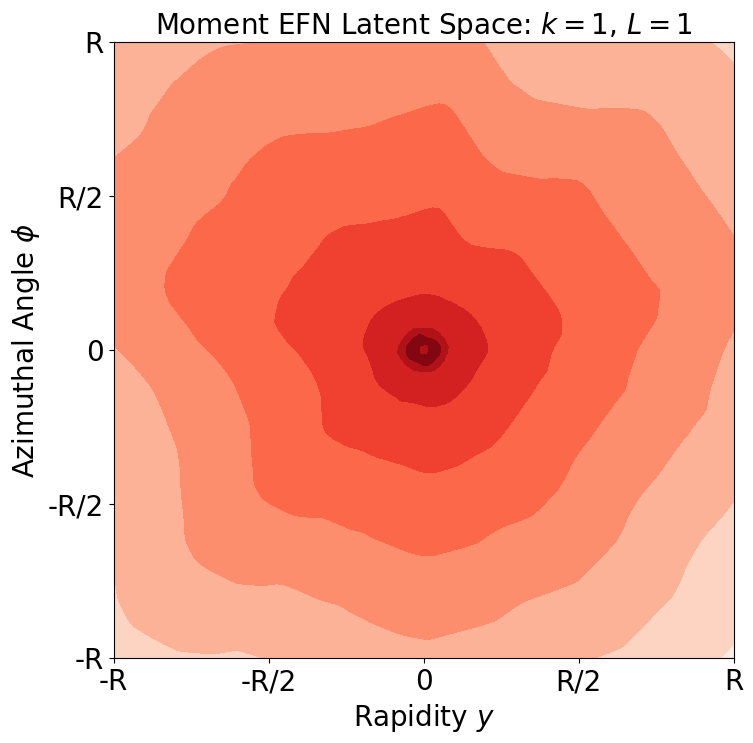

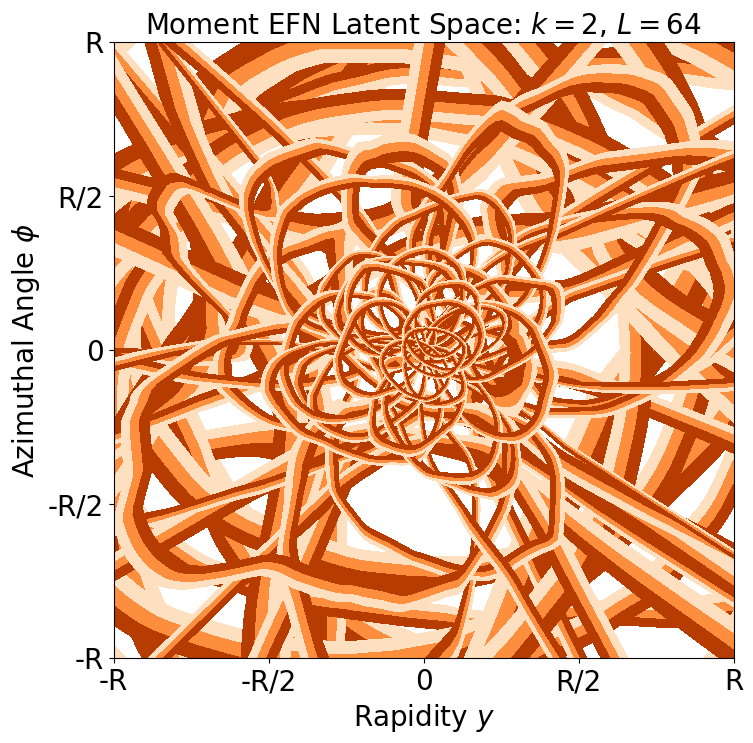

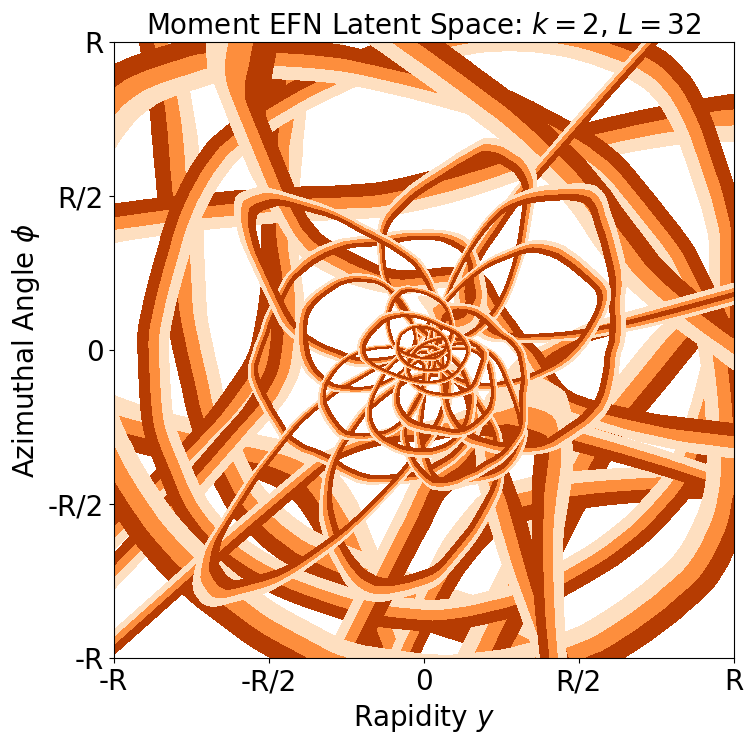

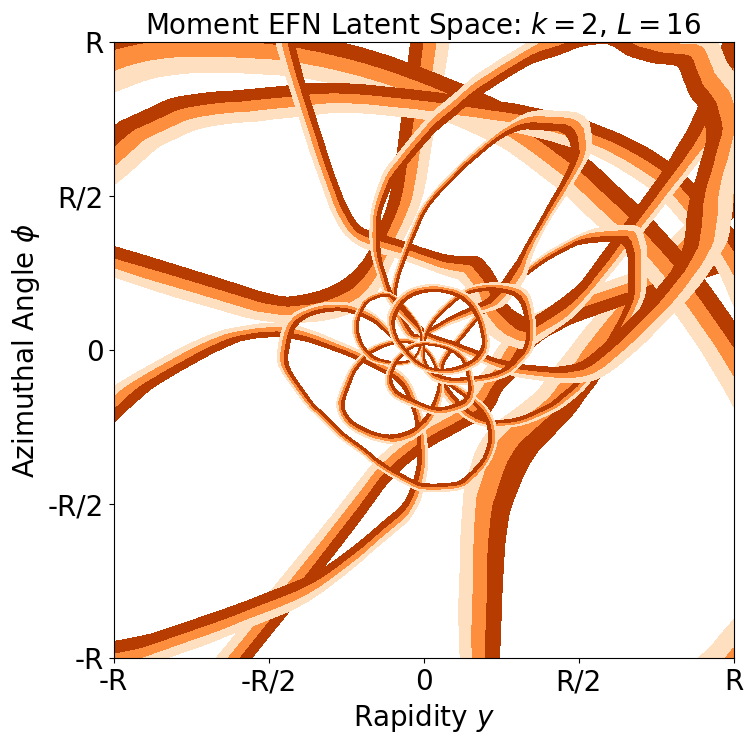

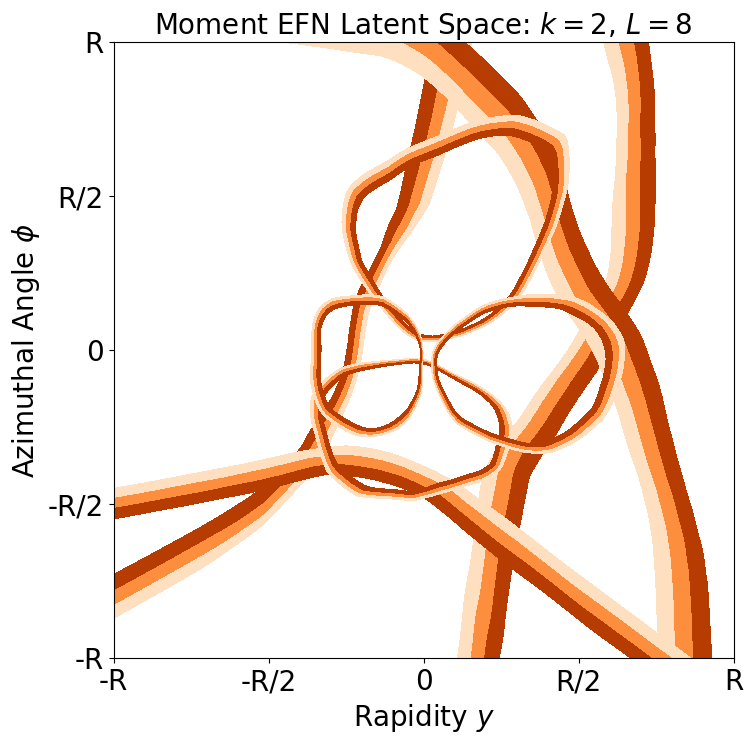

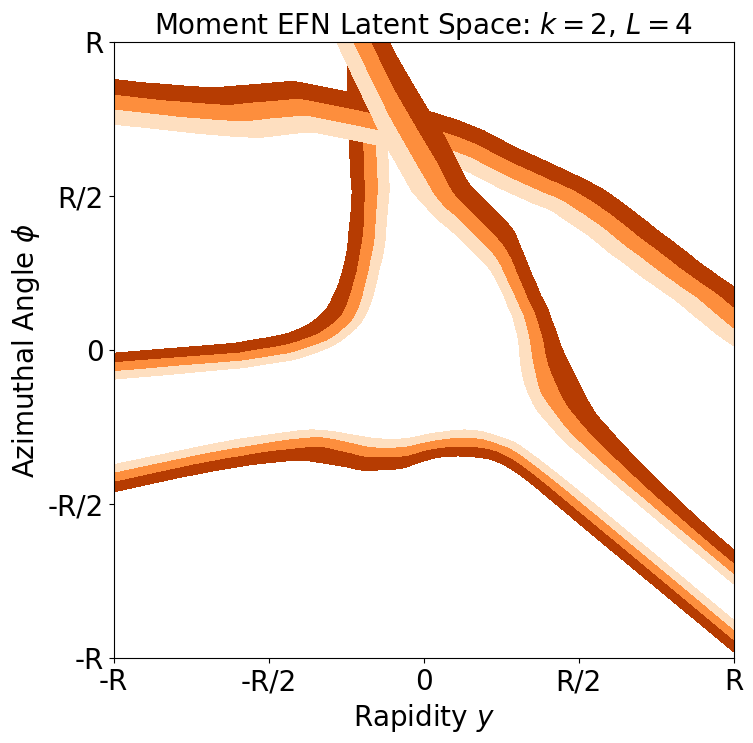

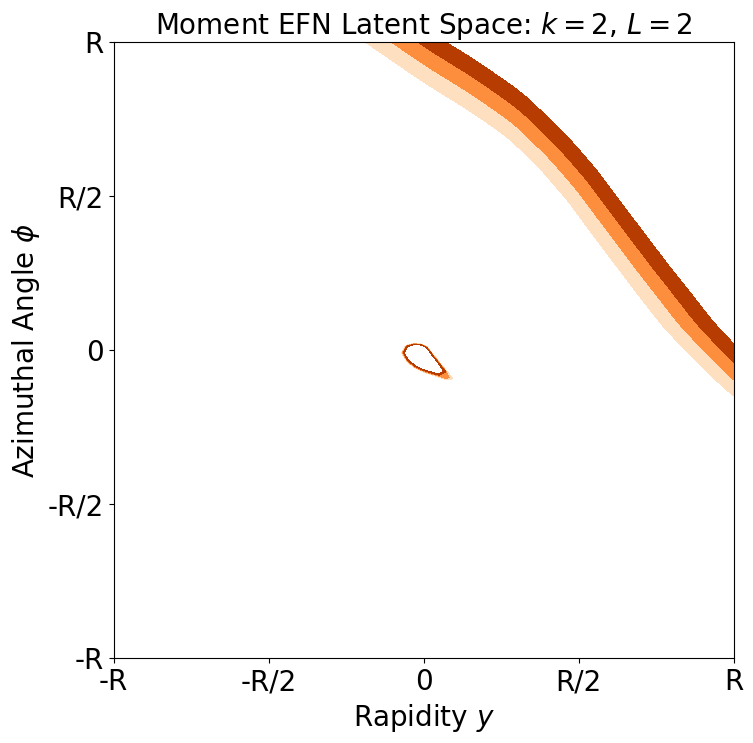

/tmp/ipykernel_43732/438350120.py:76: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contourf(X, Y, z/np.max(z), level = 25, cmap=subcolors[i % len(subcolors)])


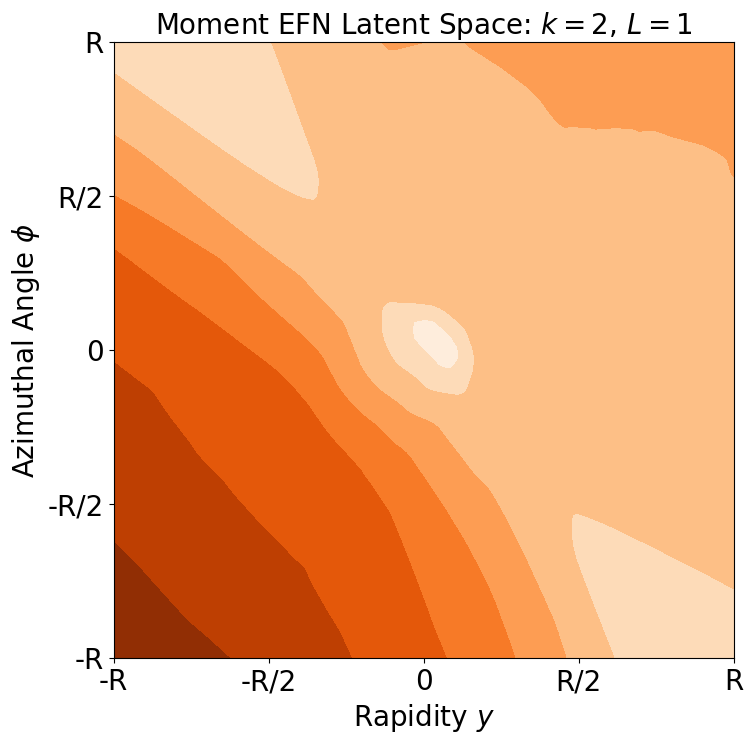

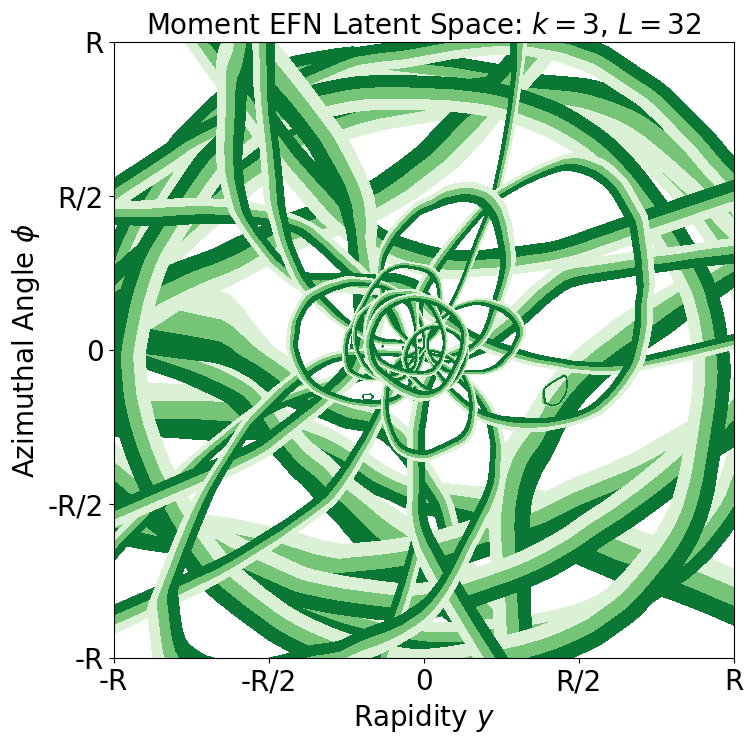

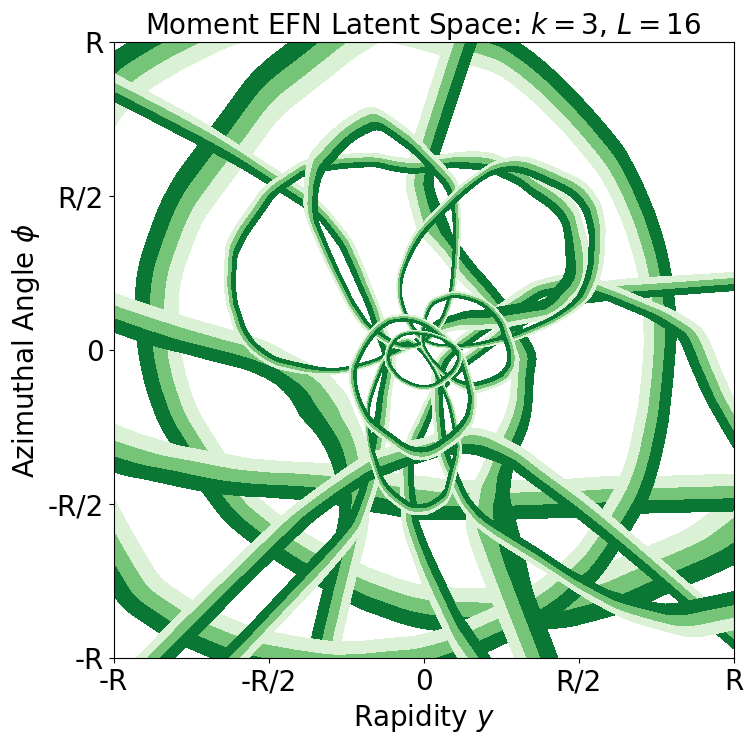

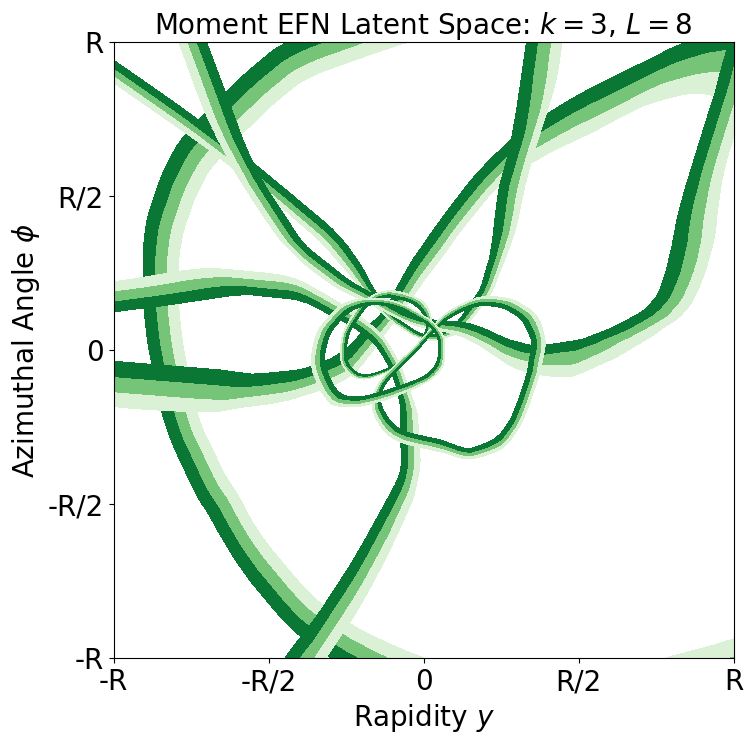

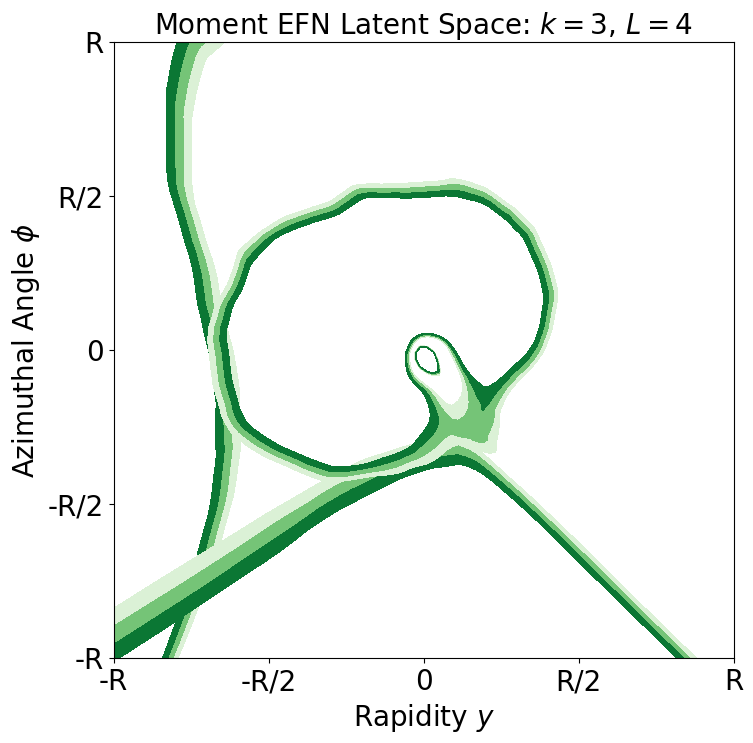

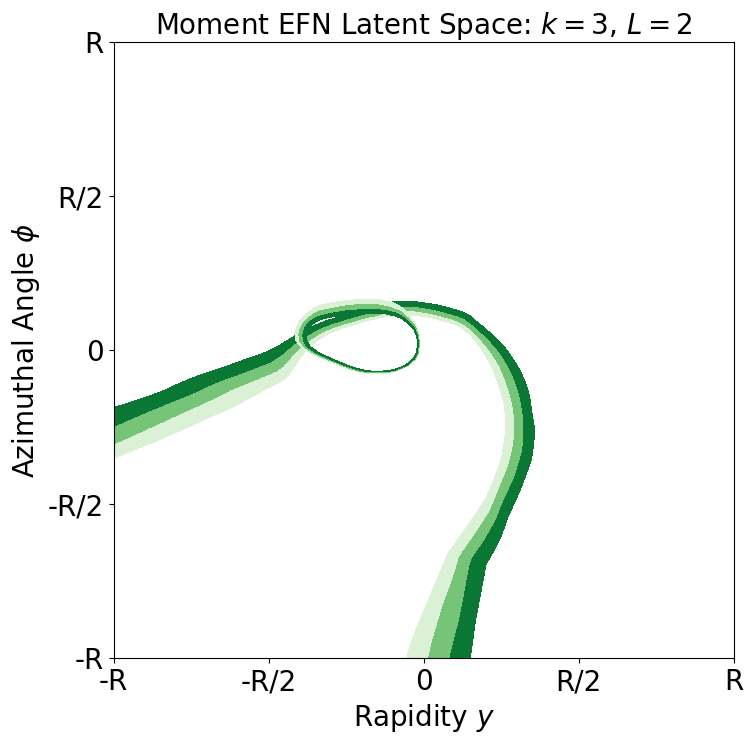

/tmp/ipykernel_43732/438350120.py:76: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contourf(X, Y, z/np.max(z), level = 25, cmap=subcolors[i % len(subcolors)])


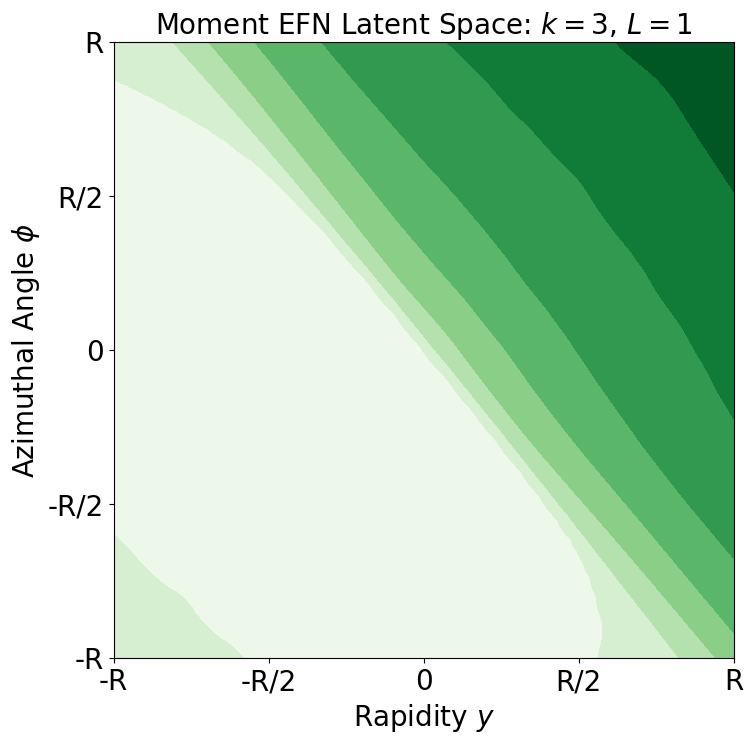

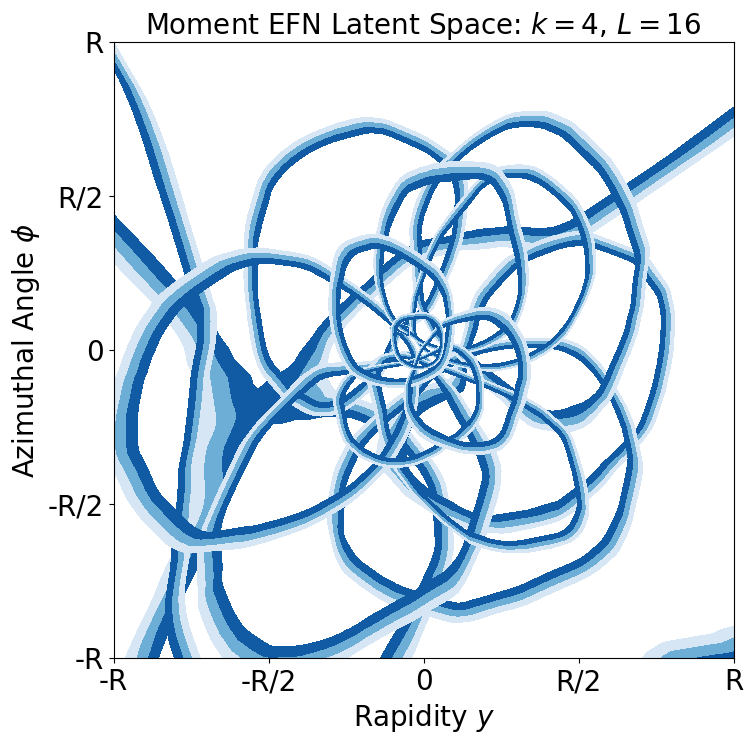

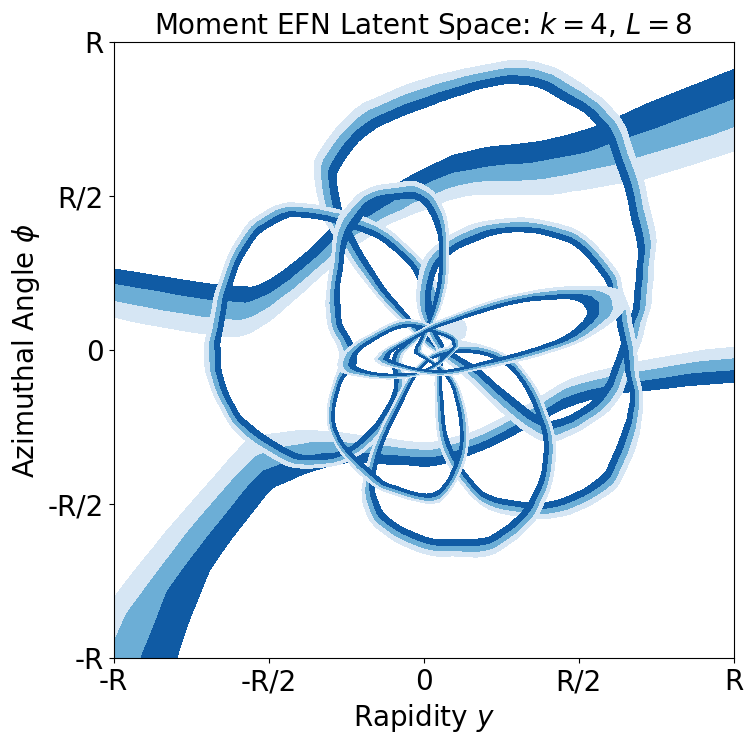

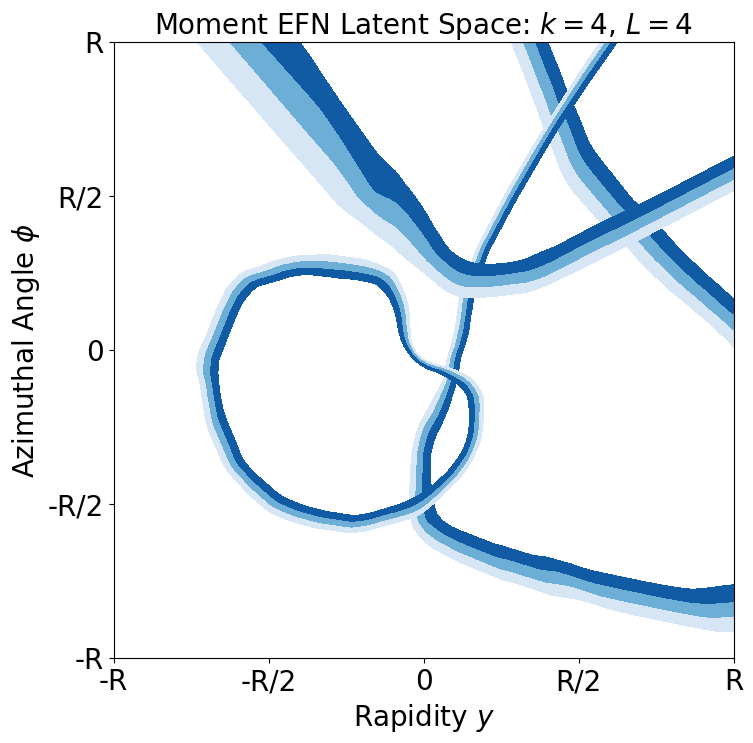

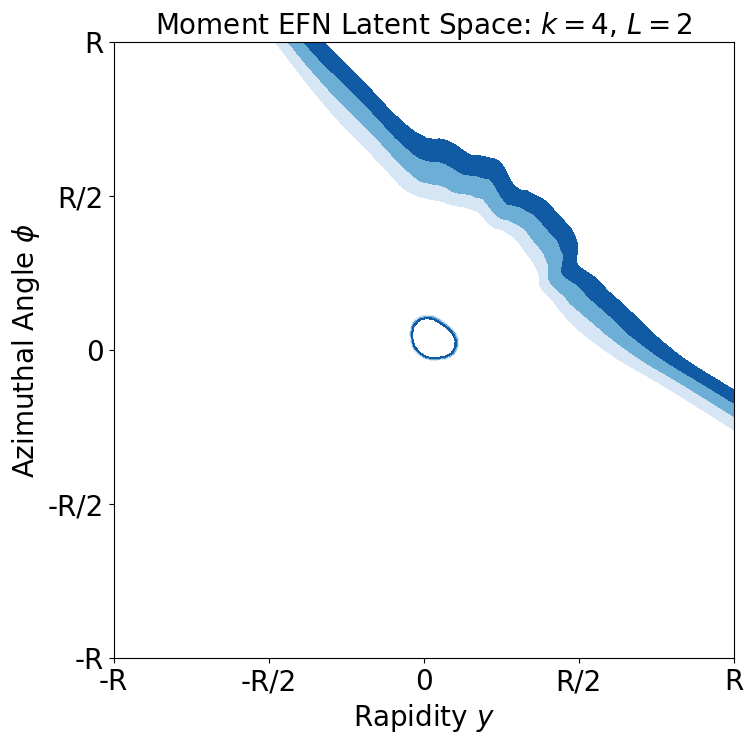

/tmp/ipykernel_43732/438350120.py:76: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contourf(X, Y, z/np.max(z), level = 25, cmap=subcolors[i % len(subcolors)])


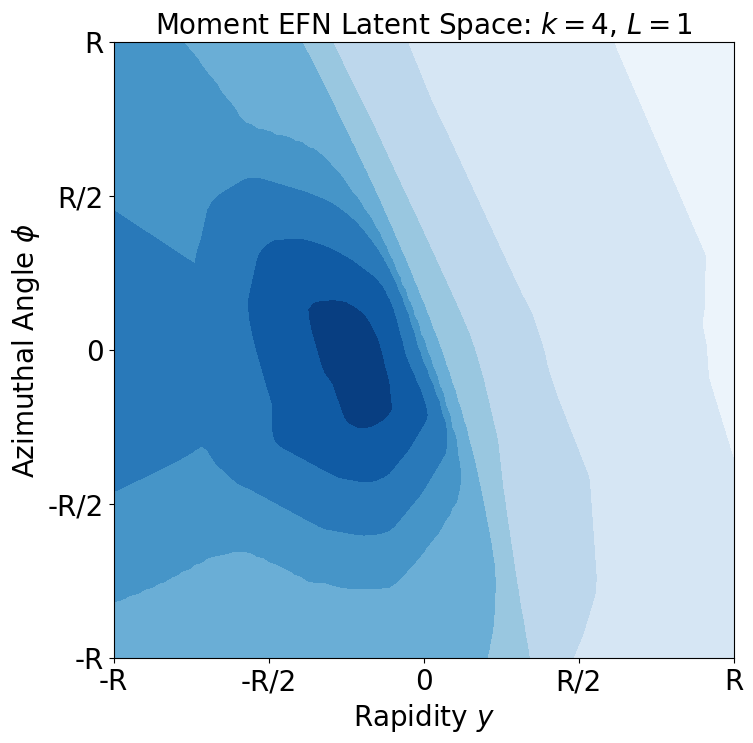

In [7]:

R, n = 0.4, 100

def plot(performance_dict):
    

    colors = ['Reds', 'Oranges', 'Greens', 'Blues', 'Purples', 'Greys']


    for p, order in enumerate(order_list):
        x = []
        y = []
        yerr= []

        for (config,info) in zip(configs['Order '+str(order)], performance_dict['Order '+str(order)]):
            
            L, F, Phi = config

            # Load model
            dictionary = {'Phi_mapping_dim' : [input_dim,L],
                                        'output_dim' : 1, 'output_act' : 'sigmoid',
                                        'Phi_sizes' : [Phi, Phi], 'Phi_acts' : 'LeakyReLU', "Phi_l1_regs" :  1e-6,
                                        'F_sizes' : [F,F,F], 'F_acts': 'LeakyReLU', "F_l1_regs" :  1e-6,
                                        'order' : order , 'architecture_type':'moment',
                                        'loss': 'binary_crossentropy','metrics': 'acc',}
            model = EFN_moment(**dictionary, summary=False)
            model_dir = os.path.join(base_directory, f"order_{order}", "Models")
            model_name = f"O{order}_L{L}_2Phi{Phi}_3F{F}"
            model.load_weights(os.path.join(model_dir , model_name + "_1.keras"), by_name = True,  skip_mismatch = True)

            X, Y, Z = model.eval_filters(R,n)
            subcolors = [colors[p]]


            fig, axes = plt.subplots(figsize=(8,8))
            plt.rcParams['font.size'] = '20'

            grads = np.linspace(0.45, 0.55, 4)
            
            def format_filter(filt):

                size, angle = get_filter_size_and_position(filt)
                minus_size, minus_angle = get_filter_size_and_position(-1 * filt)

                if minus_angle < angle:
                    filt = -filt

                filt -= np.min(filt)
                filt /= np.max(filt)

                print(np.min(filt), np.max(filt))

                return filt
            
            # for sorting filters according to position
            def get_filter_size_and_position(filt, zfrac=0.5):   
                filt /= np.max(filt)
                maxind = np.argmax(filt)
                j, k = maxind//n, maxind%n

                angle = np.sqrt((j-n/2)**2 + (k-n/2)**2)*2/n
                size = np.count_nonzero(filt > zfrac)/n**2

                return size, angle

            sizes, angles = [], []
            for z in Z:
                size, angle = get_filter_size_and_position(z)
                sizes.append(size)
                angles.append(angle)
            qg_sizes, qg_angles = np.asarray(sizes), np.asarray(angles)

            # plot filters
            for i,z in enumerate(Z[np.argsort(qg_angles)[::-1]]):
                # z = format_filter(z)
                if L == 1:
                    plt.contourf(X, Y, z/np.max(z), level = 25, cmap=subcolors[i % len(subcolors)])
                else:
                    plt.contourf(X, Y, z/np.max(z), grads, cmap=subcolors[i % len(subcolors)])


            plt.xticks(np.linspace(-R, R, 5), ['-R', '-R/2', '0', 'R/2', 'R'])
            plt.yticks(np.linspace(-R, R, 5), ['-R', '-R/2', '0', 'R/2', 'R'])
            plt.xlabel('Rapidity $y$')
            plt.ylabel('Azimuthal Angle $\phi$')
            plt.title(f'Moment EFN Latent Space: $k = {order}$, $L = {L}$', fontdict={'fontsize': 20})


            plt.savefig(os.path.join(latent_directory, f"latent_space_O{p}_L{L}.pdf"))
            plt.show()
    # plt.show()


plot(performance)

-12.868871884630341 -3.0712975605350774 0.010905729529284728


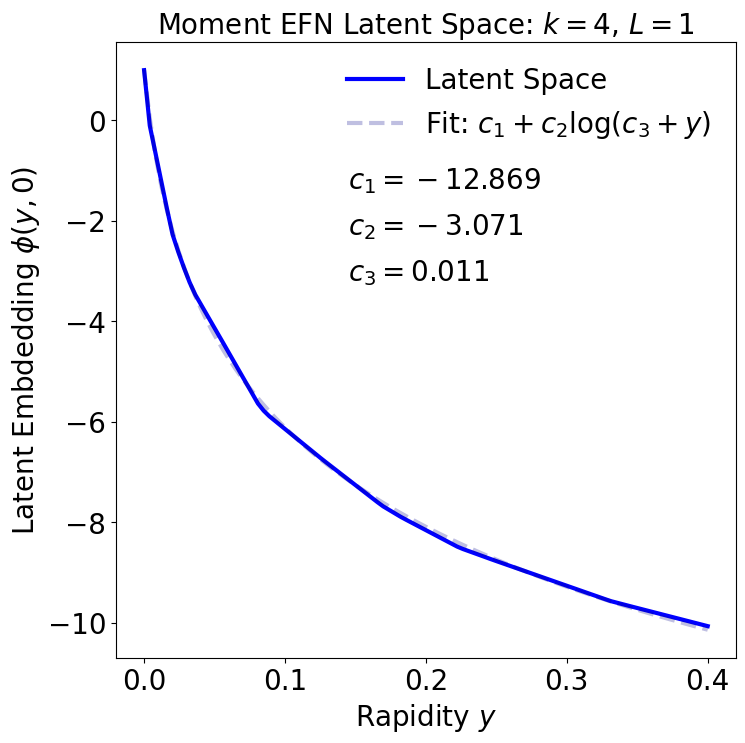

In [8]:
order = 4
L, F, Phi = 1, 100, 100

fig, axes = plt.subplots(figsize=(8,8))
plt.rcParams['font.size'] = '20'


# Load model
dictionary = {'Phi_mapping_dim' : [input_dim,L],
                            'output_dim' : 1, 'output_act' : 'sigmoid',
                            'Phi_sizes' : [Phi, Phi], 'Phi_acts' : 'LeakyReLU', "Phi_l1_regs" :  1e-6,
                            'F_sizes' : [F,F,F], 'F_acts': 'LeakyReLU', "F_l1_regs" :  1e-6,
                            'order' : order , 'architecture_type':'moment',
                            'loss': 'binary_crossentropy','metrics': 'acc',}
model = EFN_moment(**dictionary, summary=False)
model_dir = os.path.join(base_directory, f"order_{order}", "Models")
model_name = f"O{order}_L{L}_2Phi{Phi}_3F{F}"
model.load_weights(os.path.join(model_dir , model_name + "_0.keras"), by_name = True,  skip_mismatch = True)

X, Y, Z = model.eval_filters([0, 0, R, 0.000],n)

# print[Z[0,:,0]]
# plot filters
for i,z in enumerate(Z):

    x = X[:,0]
    y = z[:,0] / np.max(z[:,0])
    plt.plot(X[:,0], z[:,0] / np.max(z[:,0]), color = "blue", lw = 3, label = "Latent Space")

    a, b, c = scipy.optimize.curve_fit(lambda t,a,b,c: a+b*np.log(c + t),  x[0:],  y[0:])[0]
    y_log = a + b*np.log(x + c)
    print(a, b, c)
    # b, a = np.polyfit(np.log(x[25:]), y[15:], 1)
    plt.plot(x[0:], y_log[0:], color = "darkblue", alpha = 0.25, lw = 3, ls = "--", label = "Fit: $c_1 + c_2$log$(c_3 + y)$")

    plt.text(0.375, 0.775-0.075*0, "$c_1 = %.3f$" % a, horizontalalignment='left', verticalalignment='center', transform=axes.transAxes)
    plt.text(0.375, 0.775-0.075*1, "$c_2 = %.3f$" % b, horizontalalignment='left', verticalalignment='center', transform=axes.transAxes)
    plt.text(0.375, 0.775-0.075*2, "$c_3 = %.3f$" % c, horizontalalignment='left', verticalalignment='center', transform=axes.transAxes)

# plt.xticks(np.linspace(0, R, 5), ['0', 'R/4' 'R/2', '3R/4', 'R'])
# plt.yticks(np.linspace(-R, R, 5), ['-R', '-R/2', '0', 'R/2', 'R'])
plt.xlabel('Rapidity $y$')
plt.ylabel('Latent Embdedding $\phi(y, 0)$')
# plt.ylim(0.1, 1.1)
# plt.xscale("log")
plt.title(f'Moment EFN Latent Space: $k = {order}$, $L = {L}$', fontdict={'fontsize': 20})
plt.legend(frameon = False, loc = "upper right")

plt.savefig(os.path.join(plot_directory, "latent_fit.pdf"))


In [9]:

## training
epochs = 50
batch_size=500
callbacks =None
verbose = 2
###########

order_performance = dict()
for order in order_list:
    order_performance['Order '+str(order)] = []
    


for order in order_list:
    for i in range(num_samples):
        info = configs['Order '+str(order)][i]
        L, F, Phi = info

        container = ModelsContainer(**{'Phi_mapping_dim' : [input_dim,L],
                                      'output_dim' : 1, 'output_act' : 'sigmoid',
                                      'Phi_sizes' : [Phi, Phi], 'Phi_acts' : 'LeakyReLU',
                                      'F_sizes' : [F,F,F], 'F_acts': 'LeakyReLU',
                                      'order' : order , 'architecture_type':'moment',
                                      'loss': 'binary_crossentropy','metrics': 'acc'})
        print(i, order, info, container.num_params)
        num_params = container.num_params
        
        order_performance['Order '+str(order)].append([num_params,mean,std])

        # Just for fun, update the plot
        plot(order_performance)
   
    order_performance['Order '+str(order)] = np.array(order_performance['Order '+str(order)])

NameError: name 'num_samples' is not defined